In [1]:
import numpy as np

import matplotlib.pyplot as plt

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score

import torch
import torch.nn
import torch.optim
import torch.utils.data

import time
import math

In [2]:
import importlib
import LearningCutsUtils
import LearningCutsUtils.Utils as LCU
## needed if we change LearningCutsUtils and want to avoid reloading the kernel to see the effects
importlib.reload(LearningCutsUtils.Utils)

<module 'LearningCutsUtils.Utils' from '/home/mhance/NN-For-Cuts/LearningCutsUtils/Utils.py'>

In [3]:
from LearningCutsUtils import OneToOneLinear, EfficiencyScanNetwork
from LearningCutsUtils import loss_fn, effic_loss_fn, lossvars

In [4]:
import pandas as pd

In [5]:
x=None
y=None

if False:
    x_signal, y_signal, x_backgr, y_backgr, branches = LCU.load_random_data()
else:
    x_signal, y_signal, x_backgr, y_backgr, branches = LCU.load_SUSY_data()

num_sig_events=len(y_signal)
num_bkg_events=len(y_backgr)

N=0 # number of points

if num_bkg_events>num_sig_events:
    x = np.concatenate((x_signal,x_backgr[:num_sig_events]))
    y = np.concatenate((y_signal,y_backgr[:num_sig_events]))
    N=2*num_bkg_events
else:
    x = np.concatenate((x_signal[:num_bkg_events],x_backgr))
    y = np.concatenate((y_signal[:num_bkg_events],y_backgr))
    N=2*num_sig_events
    
m=x_signal.shape[1]

In [6]:
print(x_signal.shape)

(87938, 7)


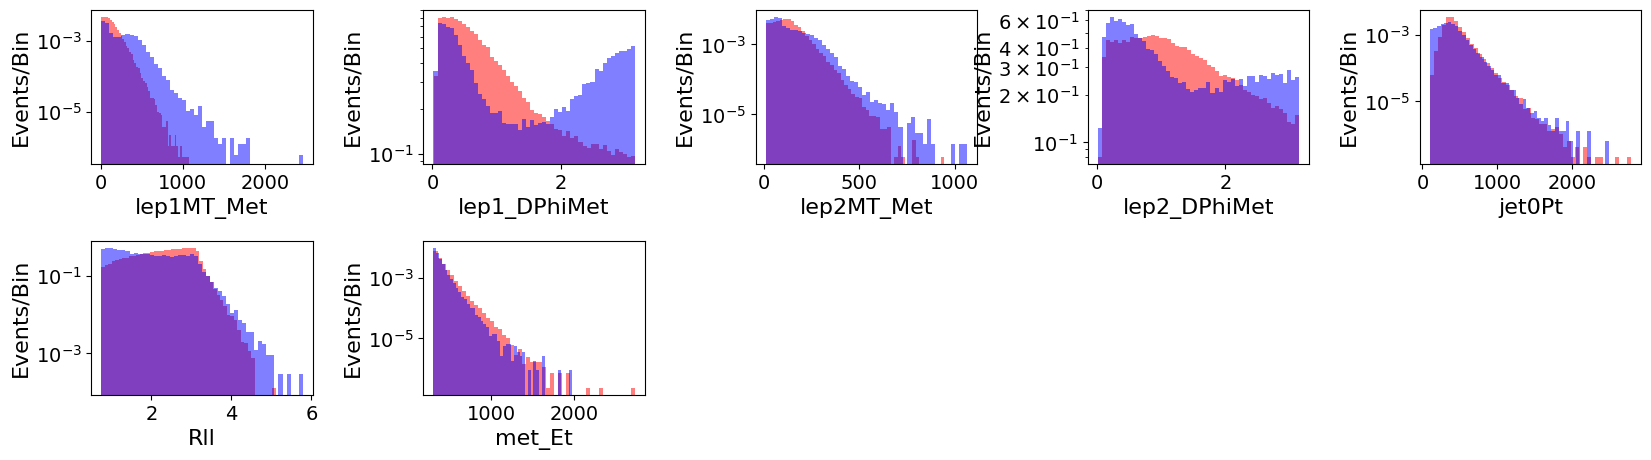

In [7]:
fig = plt.figure(figsize=(20,2.5*(int(m/5)+1)))
fig.tight_layout()
nbins=50

for b in range(m):
    ax=fig.add_subplot(int(m/5)+1,5,1+b)
    plt.subplots_adjust(hspace=0.5,wspace=0.5)
    plt.yscale('log')
    ax.hist(x_signal[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
    ax.hist(x_backgr[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
    ax.set_xlabel(f"{branches[b]}")
    ax.set_ylabel("Events/Bin")
plt.savefig("features_dummy.pdf")

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

sc = StandardScaler()
x_train_scaled = sc.fit_transform(x_train)
x_test_scaled  = sc.transform(x_test)

In [9]:
x_train_tensor=torch.tensor(x_train_scaled,dtype=torch.float)
y_train_tensor=torch.tensor(y_train,dtype=torch.float)

x_test_tensor=torch.tensor(x_test_scaled,dtype=torch.float)
y_test_tensor=torch.tensor(y_test,dtype=torch.float)

In [10]:
# some hyperparameters
learning_rate=0.5
batch_size=int(len(y_train)/1.) # only one batch
epochs=200

In [11]:
torch.manual_seed(123)

net=None

simplenet=False
if simplenet:
    net = torch.nn.Sequential(
        torch.nn.Linear(m, 1,bias=False),
        torch.nn.Sigmoid()
    )
else:
    net = torch.nn.Sequential(
        torch.nn.Linear(m, 20),
        torch.nn.ReLU(),
        torch.nn.Linear(20, 50),
        torch.nn.ReLU(),
        torch.nn.Linear(50, 20),
        torch.nn.ReLU(),
        torch.nn.Linear(20, 1),
        torch.nn.Sigmoid()
    )

torch.save(net.state_dict(), 'net_FC_untrained.pth')
#optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(net.parameters(), lr=0.05)

In [12]:
losses = []
losses_test = []

net.load_state_dict(torch.load('net_FC_untrained.pth',weights_only=True))

xy_train = torch.utils.data.TensorDataset(x_train_tensor.float(),y_train_tensor)
loader = torch.utils.data.DataLoader(xy_train, batch_size=batch_size, shuffle=True)

debug=False

for epoch in range(epochs):
    net.train()
    start_time = time.time()
    for x_batch, y_batch in loader:
        
        y_pred = net(x_batch).squeeze(1)
        optimizer.zero_grad()
        loss = torch.nn.BCELoss()(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        
    losses.append(loss.data)

    # configure the model for evaluation (testing)
    net.eval()
    
    y_pred = net(x_test_tensor).squeeze(1)
    test_loss = torch.nn.BCELoss()(y_pred, y_test_tensor)
    losses_test.append(test_loss.data)
                
    end_time=time.time()
    elapsed_time = end_time - start_time
    print(f"Completed epoch {epoch:2d} in {elapsed_time:4.1f}s, Train loss={loss.data:4.1e}, Test loss={test_loss.data:4.1e}")

torch.save(net.state_dict(), 'net_FC_trained.pth')

Completed epoch  0 in  0.7s, Train loss=7.0e-01, Test loss=6.7e-01
Completed epoch  1 in  0.8s, Train loss=6.7e-01, Test loss=6.0e-01
Completed epoch  2 in  0.8s, Train loss=6.0e-01, Test loss=5.9e-01
Completed epoch  3 in  0.6s, Train loss=5.9e-01, Test loss=5.7e-01
Completed epoch  4 in  0.8s, Train loss=5.7e-01, Test loss=5.7e-01
Completed epoch  5 in  0.8s, Train loss=5.7e-01, Test loss=5.6e-01
Completed epoch  6 in  0.9s, Train loss=5.6e-01, Test loss=5.5e-01
Completed epoch  7 in  0.6s, Train loss=5.5e-01, Test loss=5.5e-01
Completed epoch  8 in  1.3s, Train loss=5.4e-01, Test loss=5.4e-01
Completed epoch  9 in  1.3s, Train loss=5.4e-01, Test loss=5.4e-01
Completed epoch 10 in  1.5s, Train loss=5.3e-01, Test loss=5.3e-01
Completed epoch 11 in  0.9s, Train loss=5.3e-01, Test loss=5.4e-01
Completed epoch 12 in  0.8s, Train loss=5.3e-01, Test loss=5.3e-01
Completed epoch 13 in  0.8s, Train loss=5.2e-01, Test loss=5.2e-01
Completed epoch 14 in  0.8s, Train loss=5.2e-01, Test loss=5.2

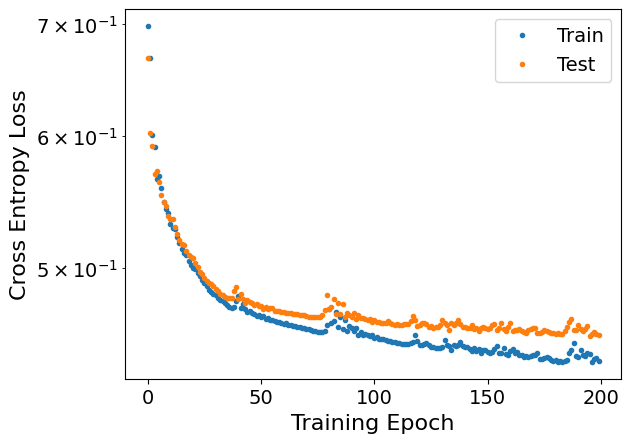

In [13]:
plt.plot(losses, '.', label="Train")
plt.plot(losses_test, '.', label="Test")
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('Cross Entropy Loss')
plt.yscale('log');

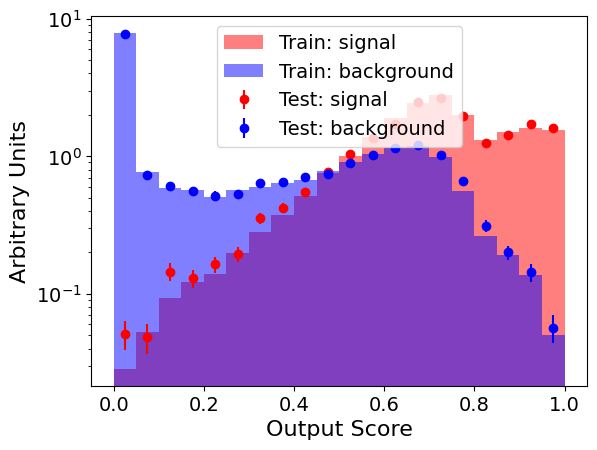

In [14]:
net.eval() # configure the model for evaluation (testing)
y_pred_test = net(x_test_tensor).detach().cpu()
y_pred_train= net(x_train_tensor).detach().cpu()

LCU.plot_classifier_output(y_train, y_pred_train, y_test, y_pred_test, nbins=20, range=(0,1))
plt.savefig("scores_FC_dummy.pdf")

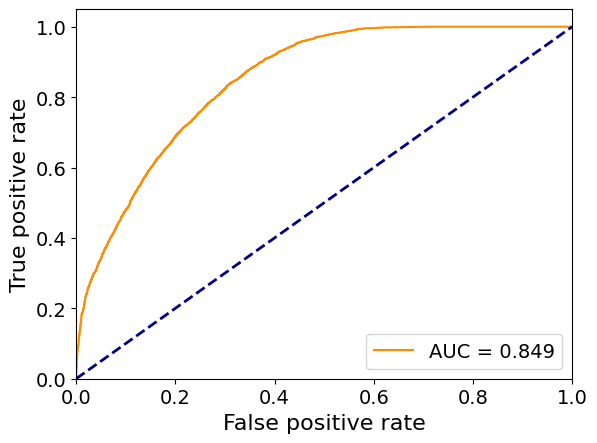

In [15]:
LCU.make_ROC_curve(y_test, y_pred_test)
plt.savefig("ROC_FC_dummy.pdf")

In [16]:
net[0].weight

Parameter containing:
tensor([[-0.5585, -0.0148, -0.2661,  0.0384, -1.1944, -0.0985,  0.1890],
        [ 0.4899, -1.1347,  0.0188,  0.1836,  0.3604, -0.3612, -0.2496],
        [-1.1687,  0.2225, -0.4892,  0.2232,  0.1577, -0.0845, -0.0318],
        [ 0.7015,  0.3480,  0.3412,  0.2494,  0.2997, -0.2773,  0.0753],
        [ 0.8859, -0.6623,  0.8588, -1.0713, -0.1732,  0.0856, -0.1648],
        [ 0.9586, -1.4627, -0.2916,  0.0335,  0.1119,  0.0915, -0.2016],
        [ 0.3729,  0.8626,  0.4494,  0.3418,  0.0748,  0.0926,  0.0230],
        [ 0.7965,  0.0466,  0.0021,  0.5239,  0.1364, -0.5445, -0.4458],
        [-0.2500, -0.8011,  0.1744, -0.3445,  0.3260,  0.2905, -0.1723],
        [-0.5819,  0.8871, -0.7014,  0.9913,  0.0320, -0.9453,  0.1207],
        [ 1.0448,  0.2191, -0.7636, -0.2976,  0.0866, -0.1269, -0.1811],
        [-1.1165,  0.0745,  0.1864, -0.1940, -0.7562,  0.4343,  0.6459],
        [ 1.0796, -0.1109, -1.1463,  0.4553,  0.6253,  0.2887, -0.6201],
        [ 0.7178, -0.7408,  0

In [17]:
net[0].bias

Parameter containing:
tensor([-0.0014, -0.5669, -0.0246,  0.5566, -0.0586, -0.2281, -0.8933,  0.1208,
        -0.7799, -0.4950,  0.1346, -0.2320, -0.2932, -0.3909, -0.1695,  0.1968,
         0.4629, -0.3847,  0.0203, -0.2100], requires_grad=True)

In [18]:
if net[0].bias is not None and False:
    -net[0].bias/net[0].weight

    fig = plt.figure(figsize=(20,5))
    fig.tight_layout()
    nbins=50
    
    biases=net[0].bias.detach().numpy()
    weights=net[0].weight.detach().numpy()
    scaled_cuts=-biases/weights
    
    cuts=sc.inverse_transform(scaled_cuts)[0]
    
    for b in range(m):
        ax=fig.add_subplot(2,5,1+b)
        plt.subplots_adjust(hspace=0.3,wspace=0.5)
        plt.yscale('log')
        ax.hist(x_signal[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
        ax.hist(x_backgr[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
        ax.set_xlabel(f"Feature {b}")
        ax.set_ylabel("Events/Bin")
        if weights[0][b] < 0:
            ax.axvline(x = cuts[b], color='g') # cut is "less than"
        else:
            ax.axvline(x = cuts[b], color='y') # cut is "greater than"

In [19]:
# some hyperparameters
learning_rate=0.5
batch_size=int(len(y_train)/1.) # only one batch
epochs=50

simplenet = torch.nn.Sequential(
    torch.nn.Linear(m, 1, bias=False),
    torch.nn.Sigmoid()
)

torch.save(simplenet.state_dict(), 'net_simpleFC_untrained.pth')
optimizer = torch.optim.SGD(simplenet.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adam(simplenet.parameters(), lr=0.05)

In [20]:
snlosses = []
snlosses_test = []

simplenet.load_state_dict(torch.load('net_simpleFC_untrained.pth',weights_only=True))

xy_train = torch.utils.data.TensorDataset(x_train_tensor.float(),y_train_tensor)
loader = torch.utils.data.DataLoader(xy_train, batch_size=batch_size, shuffle=True)

debug=False

for epoch in range(epochs):
    simplenet.train()
    start_time = time.time()
    for x_batch, y_batch in loader:
        
        y_pred = simplenet(x_batch).squeeze(1)
        optimizer.zero_grad()
        loss = torch.nn.BCELoss()(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        
    snlosses.append(loss.data)

    # configure the model for evaluation (testing)
    simplenet.eval()
    
    y_pred = simplenet(x_test_tensor).squeeze(1)
    test_loss = torch.nn.BCELoss()(y_pred, y_test_tensor)
    snlosses_test.append(test_loss.data)
                
    end_time=time.time()
    elapsed_time = end_time - start_time
    print(f"Completed epoch {epoch:2d} in {elapsed_time:4.1f}s, Train loss={loss.data:4.1e}, Test loss={test_loss.data:4.1e}")

torch.save(simplenet.state_dict(), 'net_simpleFC_trained.pth')

Completed epoch  0 in  0.8s, Train loss=7.2e-01, Test loss=6.8e-01
Completed epoch  1 in  0.6s, Train loss=6.7e-01, Test loss=6.5e-01
Completed epoch  2 in  0.7s, Train loss=6.5e-01, Test loss=6.3e-01
Completed epoch  3 in  0.8s, Train loss=6.3e-01, Test loss=6.3e-01
Completed epoch  4 in  0.8s, Train loss=6.2e-01, Test loss=6.2e-01
Completed epoch  5 in  0.7s, Train loss=6.2e-01, Test loss=6.2e-01
Completed epoch  6 in  0.8s, Train loss=6.1e-01, Test loss=6.1e-01
Completed epoch  7 in  0.6s, Train loss=6.1e-01, Test loss=6.1e-01
Completed epoch  8 in  1.0s, Train loss=6.1e-01, Test loss=6.1e-01
Completed epoch  9 in  0.7s, Train loss=6.1e-01, Test loss=6.1e-01
Completed epoch 10 in  0.8s, Train loss=6.0e-01, Test loss=6.1e-01
Completed epoch 11 in  0.8s, Train loss=6.0e-01, Test loss=6.1e-01
Completed epoch 12 in  0.6s, Train loss=6.0e-01, Test loss=6.1e-01
Completed epoch 13 in  0.8s, Train loss=6.0e-01, Test loss=6.0e-01
Completed epoch 14 in  0.6s, Train loss=6.0e-01, Test loss=6.0

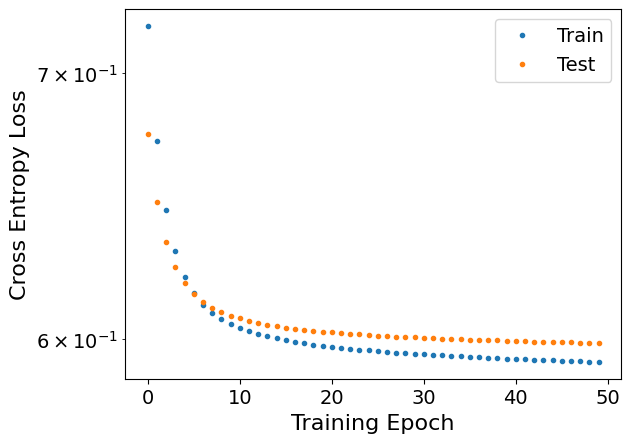

In [21]:
plt.plot(snlosses, '.', label="Train")
plt.plot(snlosses_test, '.', label="Test")
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('Cross Entropy Loss')
plt.yscale('log');

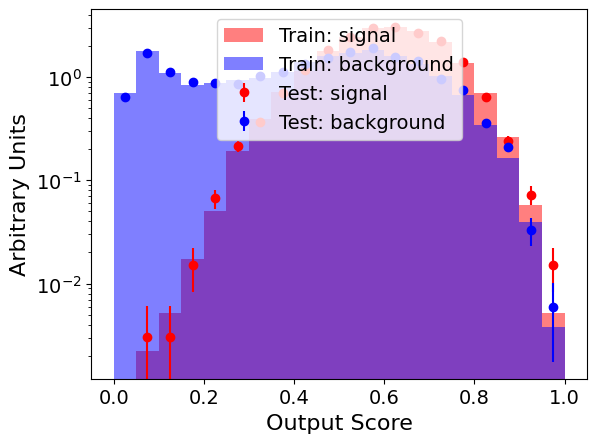

In [22]:
simplenet.eval() # configure the model for evaluation (testing)
y_pred_test = simplenet(x_test_tensor).detach().cpu()
y_pred_train= simplenet(x_train_tensor).detach().cpu()

LCU.plot_classifier_output(y_train, y_pred_train, y_test, y_pred_test, nbins=20, range=(0,1))
plt.savefig("scores_simpleFC_dummy.pdf")

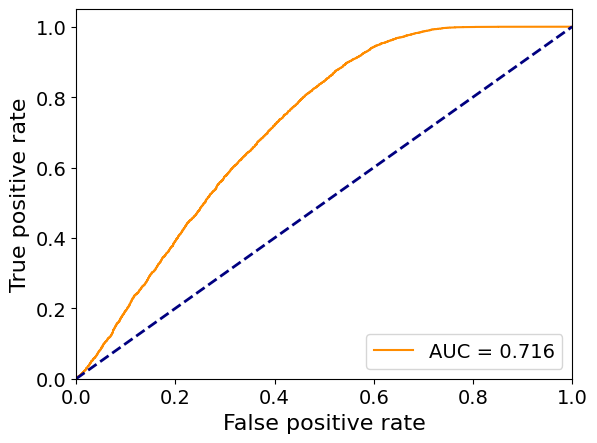

In [23]:
LCU.make_ROC_curve(y_test, y_pred_test)
plt.savefig("ROC_simpleFC_dummy.pdf")